# Ensemble: pr/prra/prsn (over sea-ice and ocean)

## Imports & defaults

In [1]:
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'pr'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = '''total precipitation (solid), rainfall (dashed), snowfall (dashdot), 
and evaporation (dotted) over sea-ice and ocean'''

time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Precipitation ({time_series_units})'
time_series_y_range = (0, 2.25)
time_series_y_range_monthly = (0, 3)
time_series_process = lambda x: x

In [3]:
ensemble_pr_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)
ensemble_pr_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment, suffix='_smooth')
)

# ----- prra -----
ensemble_prra_time_series = time_series_process(
    libs.local.get_ensemble_series('prra', experiment)
)
ensemble_prra_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('prra', experiment, suffix='_smooth')
)
for variable in ensemble_prra_time_series:
    ensemble_prra_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    ensemble_prra_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }

# ----- prsn -----
ensemble_prsn_time_series = time_series_process(
    libs.local.get_ensemble_series('prsn', experiment)
)
ensemble_prsn_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('prsn', experiment, suffix='_smooth')
)
for variable in ensemble_prsn_time_series:
    ensemble_prsn_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    ensemble_prsn_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }

# ----- tas -----
ensemble_tas_time_series = libs.local.get_ensemble_series('tas', experiment)
ensemble_tas_time_series_smooth = libs.local.get_ensemble_series('tas', experiment, suffix='_smooth')
ensemble_tas_time_series /= 10

# ----- evspsbl -----
ensemble_evspsbl_time_series = libs.local.get_ensemble_series('evspsbl', experiment)
ensemble_evspsbl_time_series_smooth = libs.local.get_ensemble_series('evspsbl', experiment, suffix='_smooth')

for variable in ensemble_evspsbl_time_series:
    ensemble_evspsbl_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }
    ensemble_evspsbl_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }


time_slices = libs.vars.default_time_slices()

## Time series

### Mean

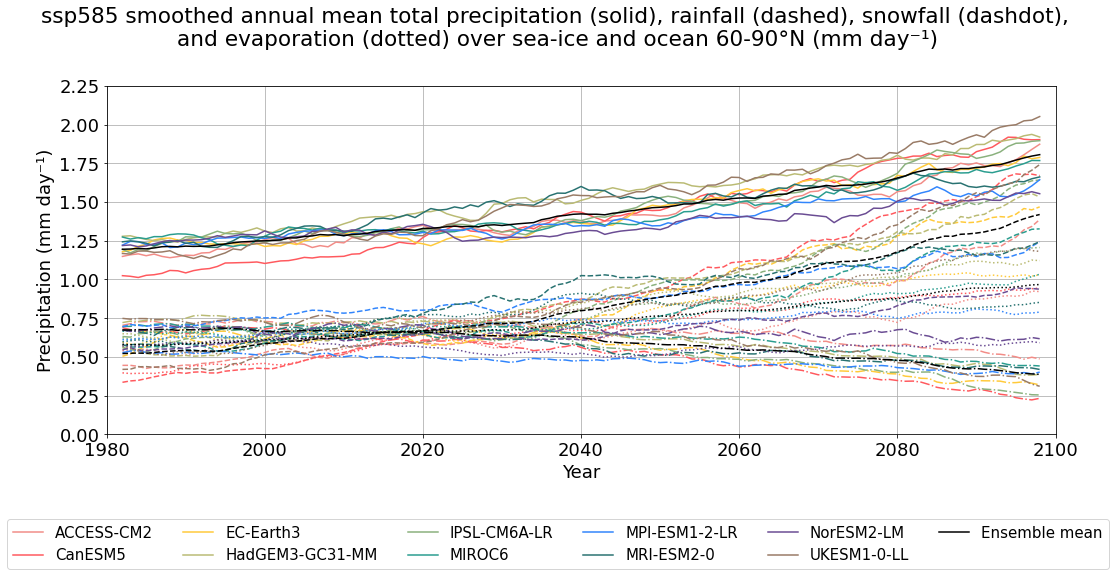

In [4]:
# libs.plot.time_series_from_vars(
#     [
#         ensemble_pr_time_series_smooth,
#         ensemble_prsn_time_series_smooth,
#         ensemble_prra_time_series_smooth,
#         ensemble_evspsbl_time_series_smooth
#     ],
#     title=f'{experiment} smoothed mean\n{time_series_text} 60-90°N ({time_series_units})',
#     xattr='time',
#     ylabel=time_series_y_label,
#     yrange=time_series_y_range
# );

vars_series = [
    ensemble_pr_time_series,
    ensemble_prsn_time_series,
    ensemble_prra_time_series,
    ensemble_evspsbl_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)

plot_arr[1]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
plot_arr[2]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
plot_arr[3]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }

libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed annual mean {time_series_text} 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

### Ratios

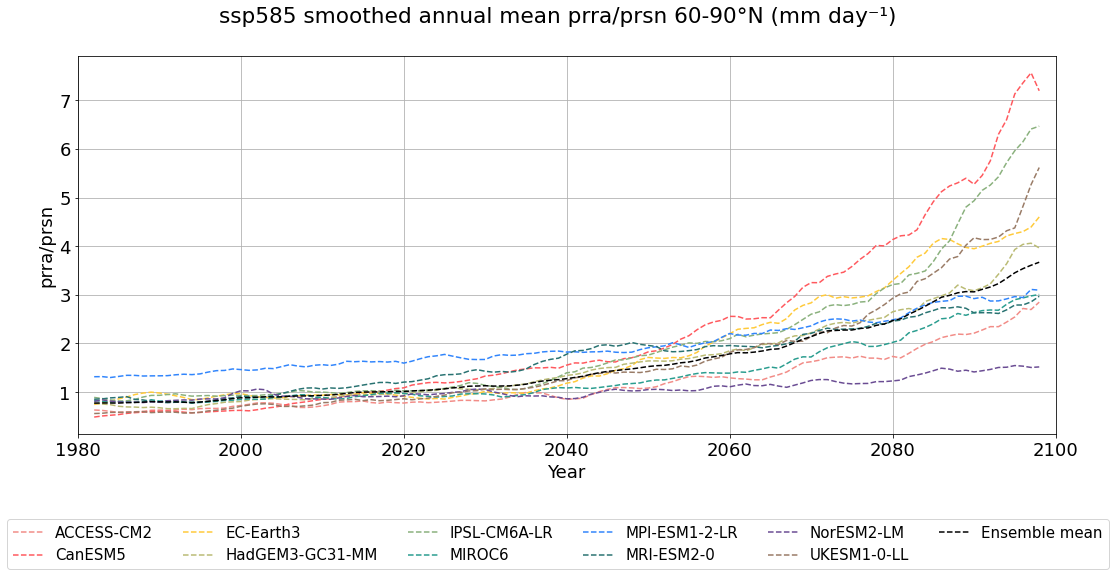

In [5]:
libs.plot.time_series_from_vars(
    [
        plot_arr[2] / plot_arr[1],
    ],
    title=f'{experiment} smoothed annual mean prra/prsn 60-90°N ({time_series_units})',
    xattr='year',
    ylabel='prra/prsn',
    #yrange=time_series_y_range
);

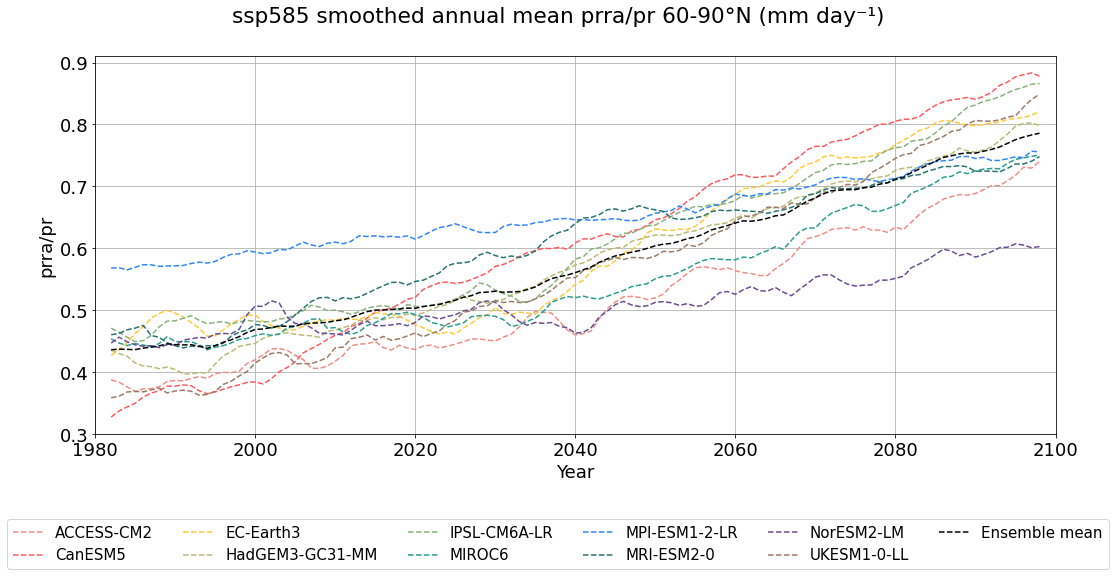

In [6]:
libs.plot.time_series_from_vars(
    [
        plot_arr[2] / plot_arr[0],
    ],
    title=f'{experiment} smoothed annual mean prra/pr 60-90°N ({time_series_units})',
    xattr='year',
    ylabel='prra/pr',
    #yrange=time_series_y_range
);

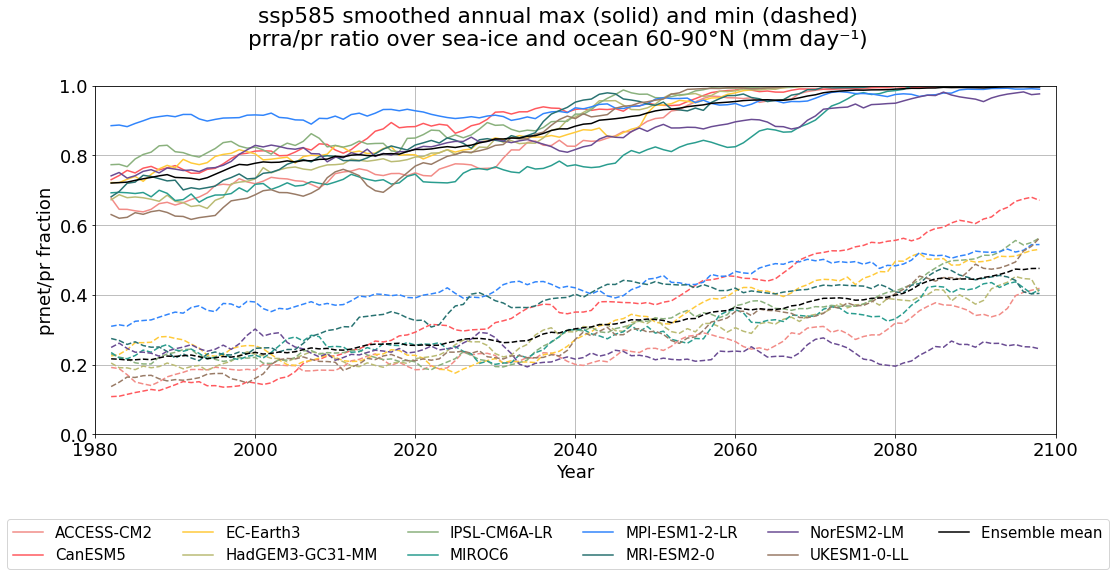

In [7]:
vars_series = [
    ensemble_prra_time_series / ensemble_pr_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').max('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    for key in item_processed: 
        item_processed[key].attrs['plot_kwargs'] = { 'linestyle': 'solid' }
    plot_arr.append(item_processed)
    
    item_processed = item.groupby('time.year').min('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    for key in item_processed: 
        item_processed[key].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    plot_arr.append(item_processed)

libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed annual max (solid) and min (dashed)\nprra/pr ratio over sea-ice and ocean 60-90°N ({time_series_units})',
    xattr='year',
    ylabel='prnet/pr fraction',
    yrange=(0, 1)
);

## Monthly variability

### Full region (time)

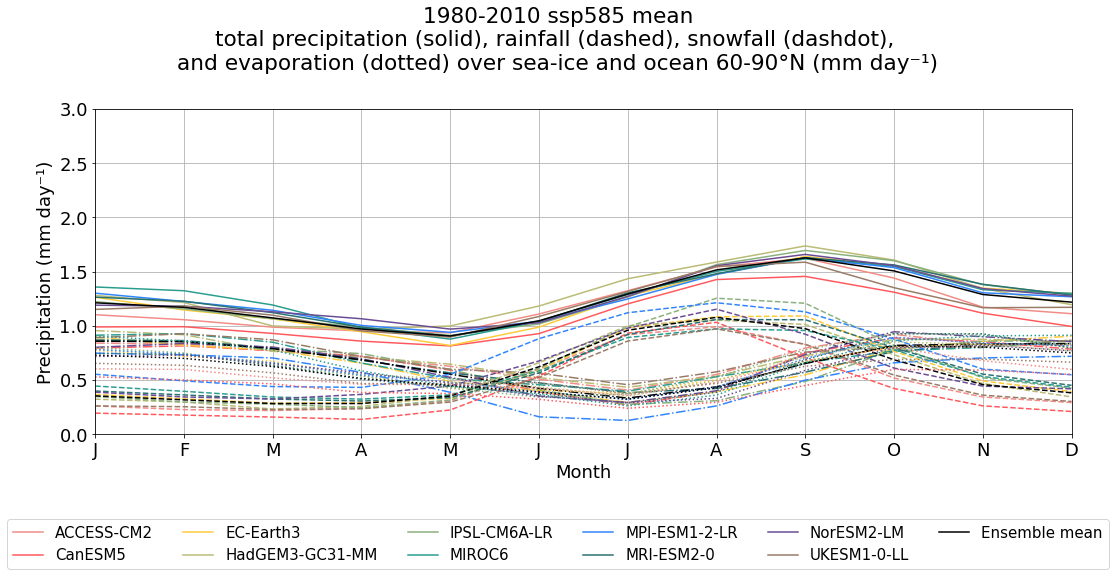

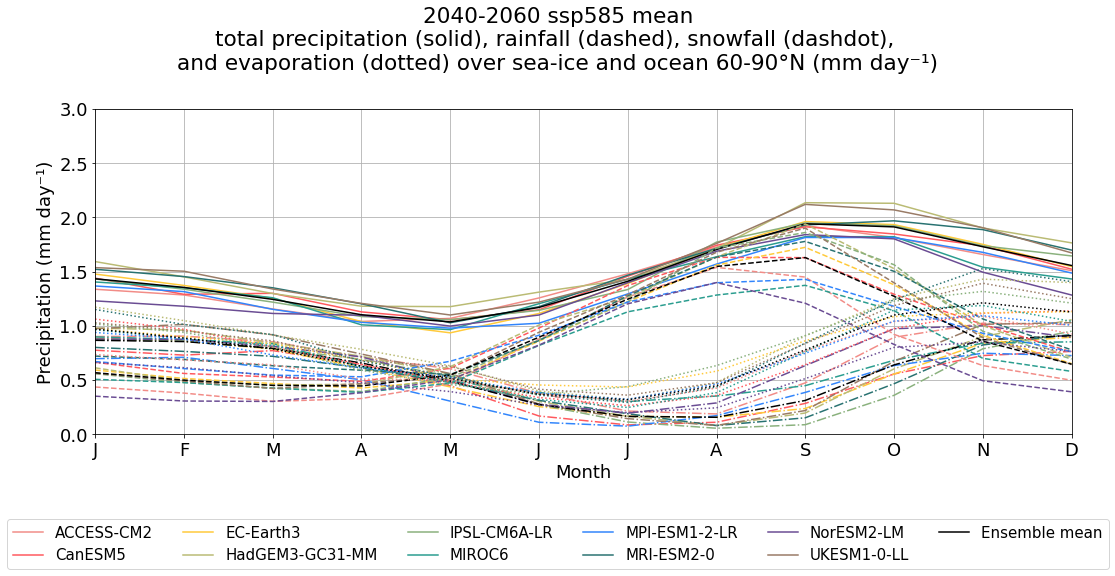

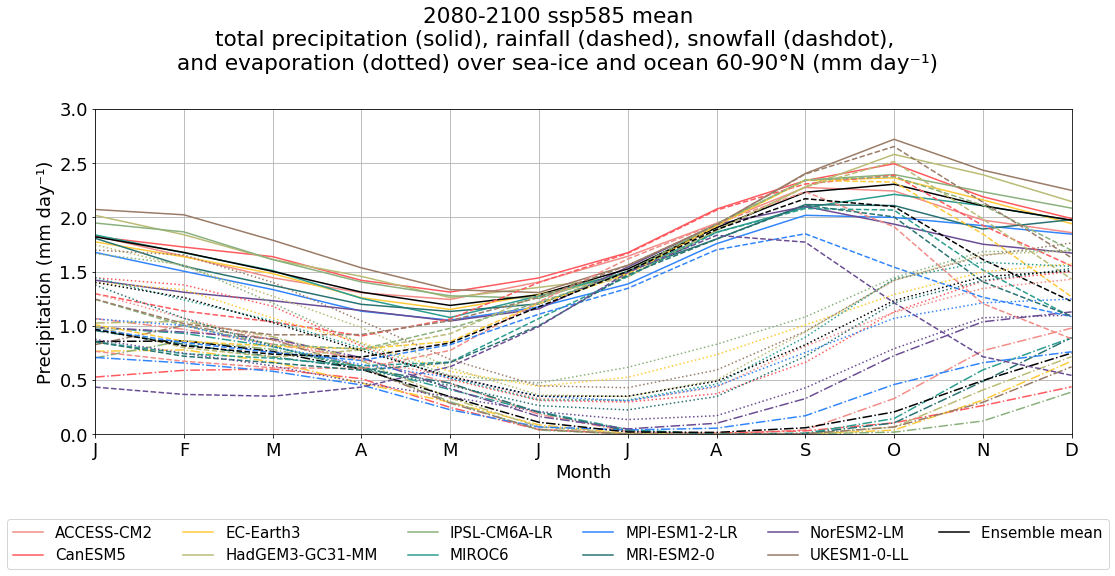

In [8]:
for s in time_slices:
    s_label = s['label']

    libs.plot.monthly_variability(
        [
            ensemble_pr_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
            ensemble_prsn_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
            ensemble_prra_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
            ensemble_evspsbl_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
        ],
        title=f'{s_label} {experiment} mean\n{time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    )

### Ratio prra/pr

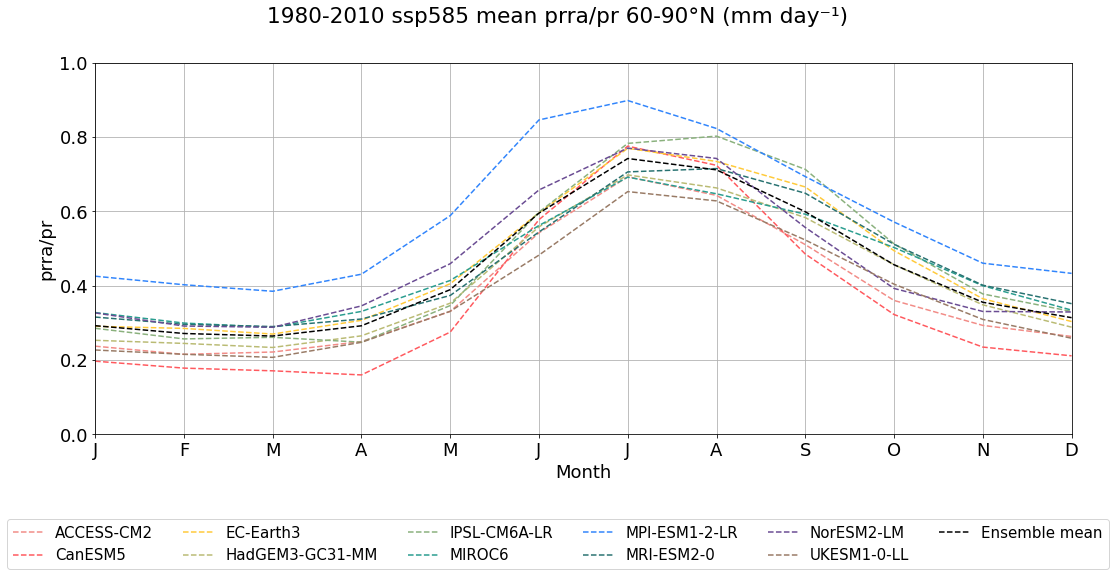

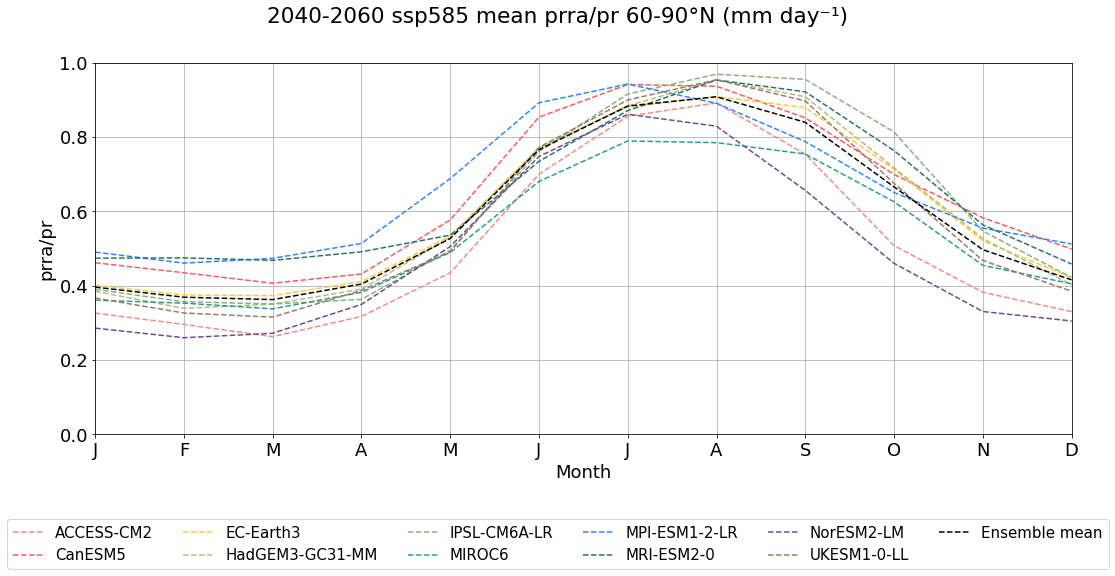

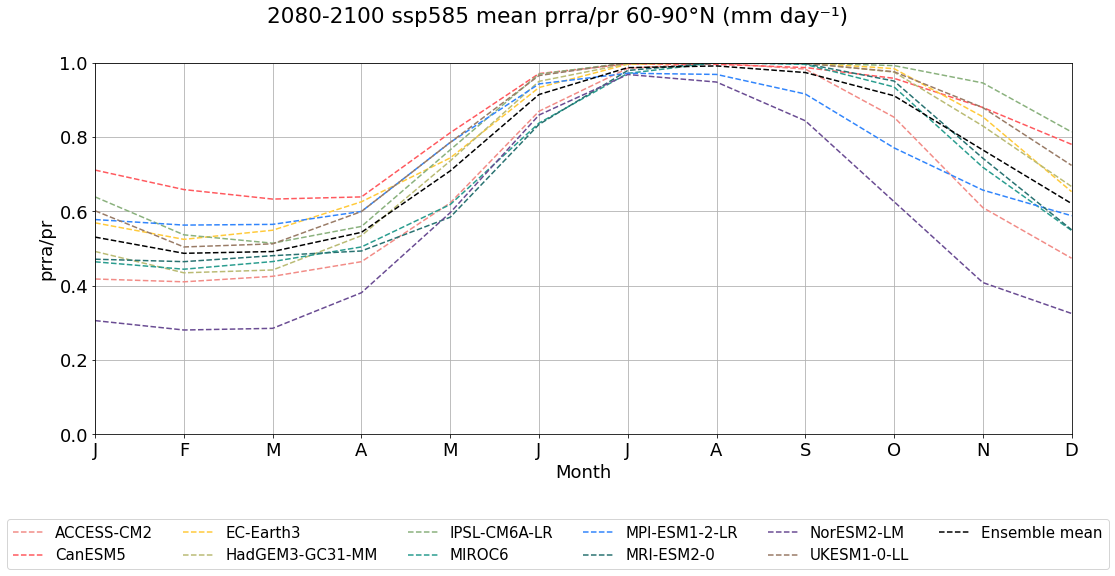

In [9]:
for s in time_slices:
    s_label = s['label']
    
    s_pr = ensemble_pr_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    s_prra = ensemble_prra_time_series.sel(**s['slice']).groupby('time.month').mean('time')

    libs.plot.monthly_variability(
        [
            s_prra / s_pr
        ],
        title=f'{s_label} {experiment} mean prra/pr 60-90°N ({time_series_units})',
        ylabel='prra/pr',
        yrange=(0, 1)
    )

## Rain season length

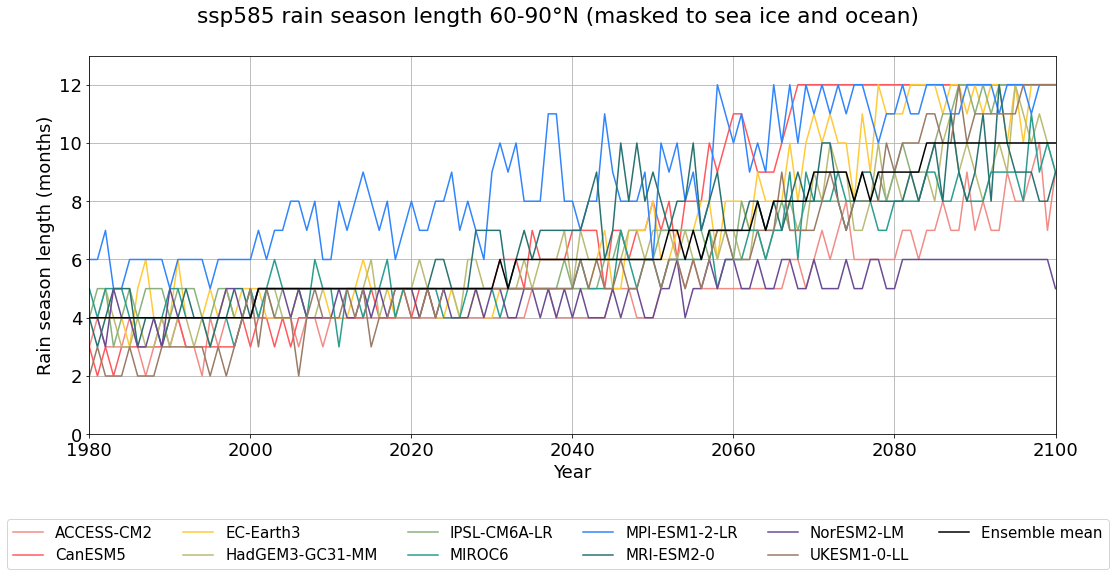

In [10]:
ensemble_rain_season_length = ensemble_pr_time_series.copy()
for key in ensemble_rain_season_length:
    ensemble_rain_season_length[key] = ensemble_rain_season_length[key]\
        .where(ensemble_prra_time_series[key] > ensemble_prsn_time_series[key])\
        .groupby('time.year')\
        .count('time')

ensemble_rain_season_length = libs.ensemble.calc_variable_mean(ensemble_rain_season_length, 'time')
ensemble_rain_season_length['Ensemble mean'] = ensemble_rain_season_length['Ensemble mean'].round()

fig = libs.plot.time_series_from_vars(
    [
        ensemble_rain_season_length
    ],
    title=f'{experiment} rain season length 60-90°N (masked to sea ice and ocean)',
    xattr='year',
    ylabel='Rain season length (months)',
    yrange=(0, 13)
);

#data = ensemble_rain_season_length
#data_min = data.to_array('time').min('time')
#data_max = data.to_array('time').max('time')

#fig.axes[0].fill_between(
#    data.year.values,
#    data_min.values,
#    data_max.values,
#    alpha=0.05,
#    color=data['Ensemble mean'].attrs['color'],
#    zorder=-1
#);

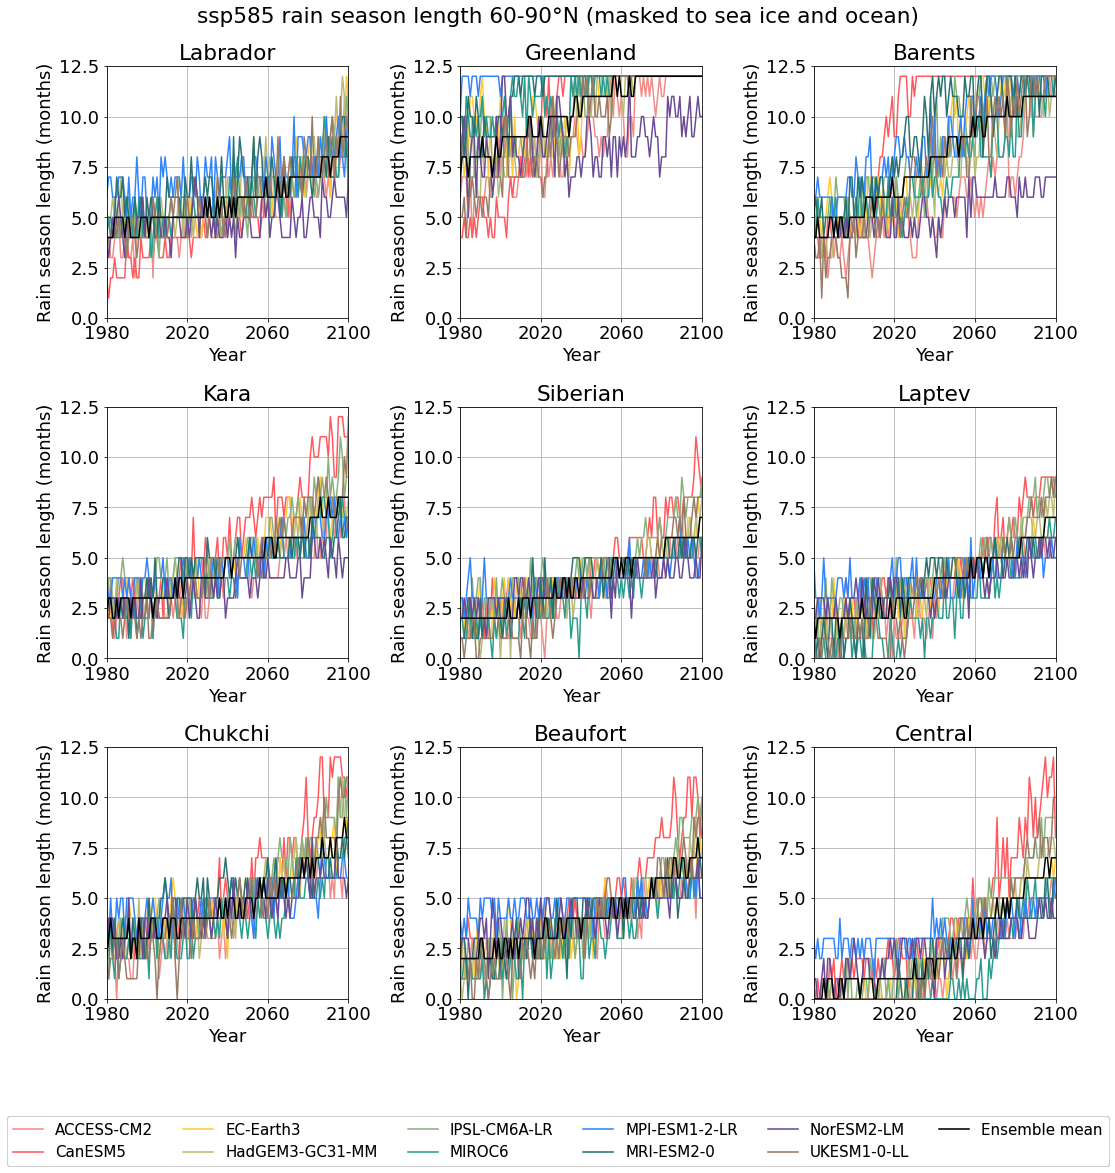

In [11]:
regions_prra = libs.local.get_ensemble_regional_series('prra', experiment)
regions_prsn = libs.local.get_ensemble_regional_series('prsn', experiment)

fig, axes = plt.subplots(*(3, 3), figsize=(15, 15))
axes = axes.flatten()
fig.suptitle(f'{experiment} rain season length 60-90°N (masked to sea ice and ocean)')

for i, data_prra in enumerate(regions_prra):
    ensemble_rain_season_length = data_prra.copy()
    data_prsn = regions_prsn[i]
    region = data_prra.attrs['region']

    for key in ensemble_rain_season_length:
        ensemble_rain_season_length[key] = ensemble_rain_season_length[key]\
            .where(data_prra[key] > data_prsn[key])\
            .groupby('time.year')\
            .count('time')

    ensemble_rain_season_length = libs.ensemble.calc_variable_mean(ensemble_rain_season_length, 'time')
    ensemble_rain_season_length['Ensemble mean'] = ensemble_rain_season_length['Ensemble mean'].round()
        
    fig = libs.plot.time_series_from_vars(
        [
            ensemble_rain_season_length
        ],
        ax=axes[i],
        fig=fig,
        xattr='year',
        ylabel='Rain season length (months)',
        yrange=(0, 12.5)
    )
    
    axes[i].set_title(region)
    axes[i].set_xticks([1980, 2020, 2060, 2100])

### Rain season first month

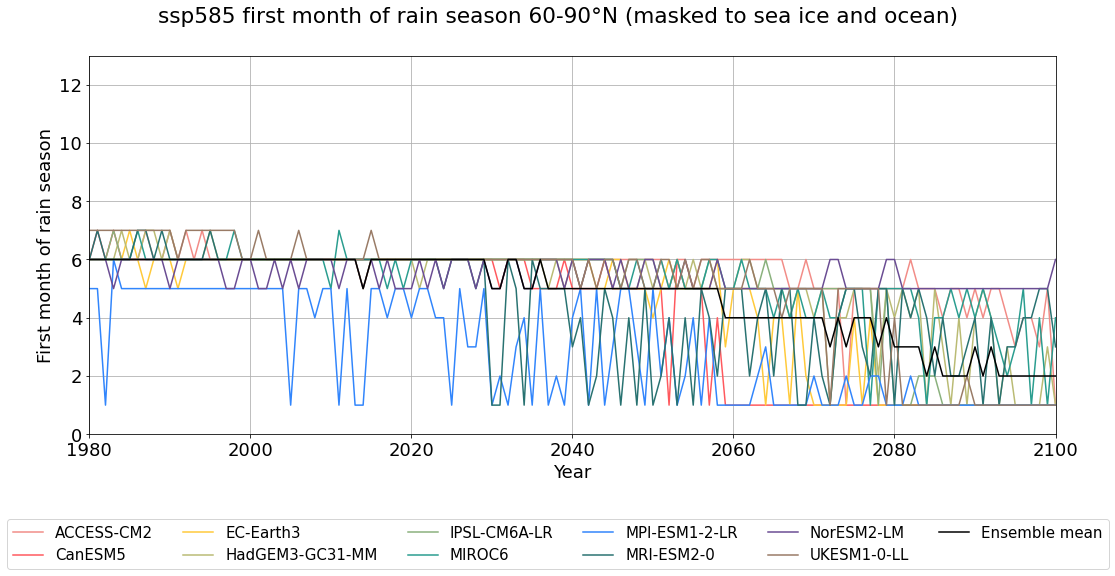

In [12]:
def get_first_month(x):
    for i, v in enumerate(x.values):
        if np.isnan(v):
            continue
            
        return x.time.values[i].month
    
    return np.nan


def create_first_month_dataset(base_series, ensemble_prra_time_series, ensemble_prsn_time_series):
    ensemble_rain_season_month = base_series.copy()
    data_vars = {}
    years = []
    for key in ensemble_rain_season_month:
        grouped = ensemble_rain_season_month[key]\
            .where(ensemble_prra_time_series[key] > ensemble_prsn_time_series[key])\
            .groupby('time.year')

        years = [year_ds[0] for year_ds in grouped]
        vals = [get_first_month(year_ds[1]) for year_ds in grouped]

        data_vars[key] = ('year', vals)


    ensemble_rain_season_month = xarray.Dataset(
        data_vars=data_vars,
        coords={ 'year': years }
    )
    
    for key in ensemble_rain_season_month:
        ensemble_rain_season_month[key].attrs = base_series[key].attrs

    ensemble_rain_season_month = libs.ensemble.calc_variable_mean(ensemble_rain_season_month, 'time')
    ensemble_rain_season_month['Ensemble mean'] = ensemble_rain_season_month['Ensemble mean'].round()
    
    return ensemble_rain_season_month


ensemble_rain_season_month = create_first_month_dataset(
    ensemble_pr_time_series,
    ensemble_prra_time_series,
    ensemble_prsn_time_series
)

fig = libs.plot.time_series_from_vars(
    [
        ensemble_rain_season_month
    ],
    title=f'{experiment} first month of rain season 60-90°N (masked to sea ice and ocean)',
    xattr='year',
    ylabel='First month of rain season',
    yrange=(0, 13)
);

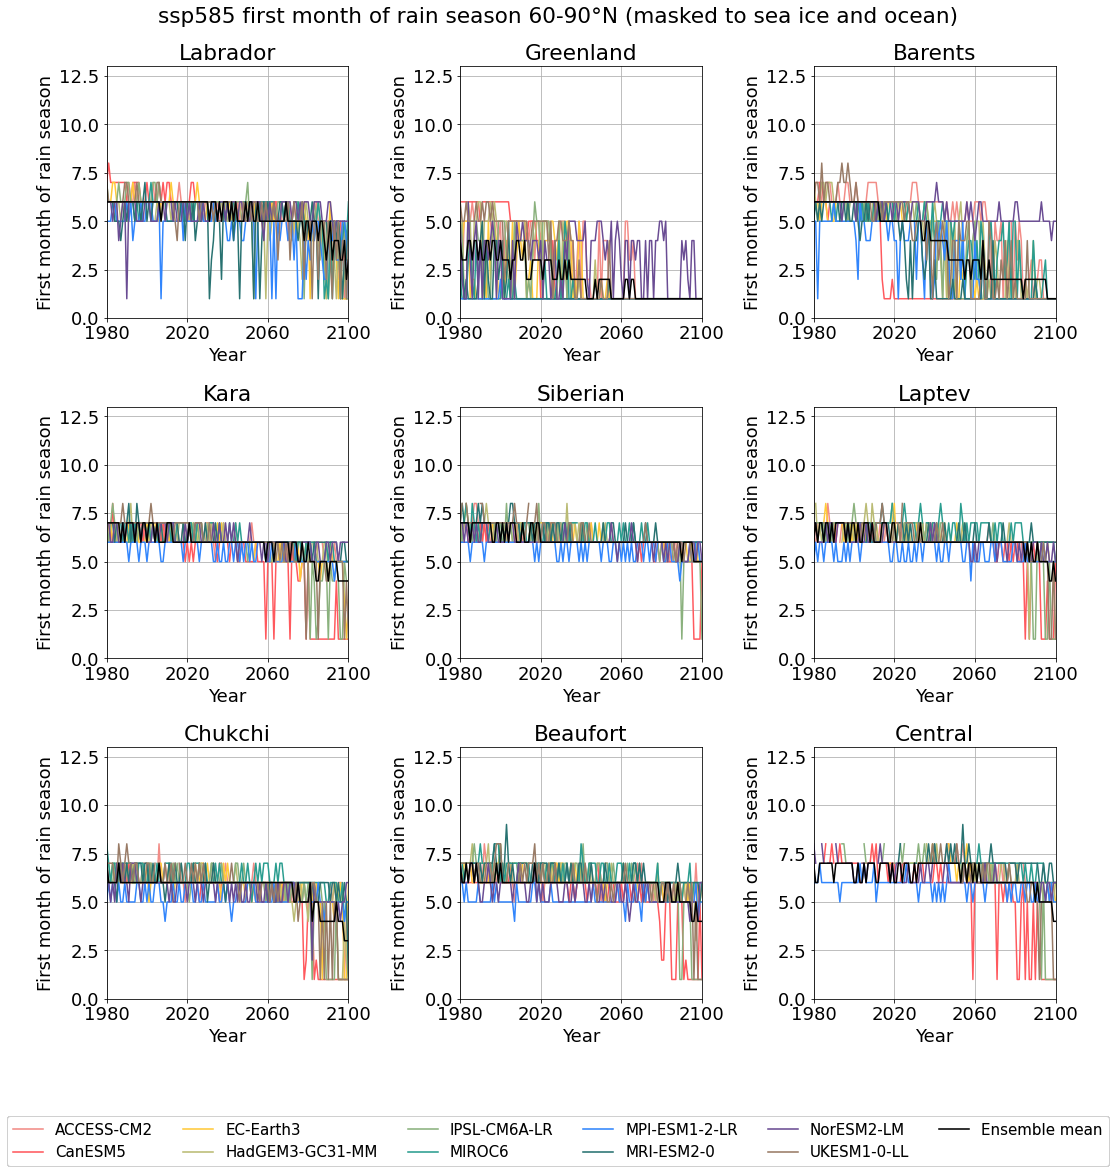

In [13]:
fig, axes = plt.subplots(*(3, 3), figsize=(15, 15))
axes = axes.flatten()
fig.suptitle(f'{experiment} first month of rain season 60-90°N (masked to sea ice and ocean)')

for i, data_prra in enumerate(regions_prra):
    data_prsn = regions_prsn[i]
    region = data_prra.attrs['region']
    
    ensemble_rain_season_month = create_first_month_dataset(
        data_prra,
        data_prra,
        data_prsn
    )
        
    fig = libs.plot.time_series_from_vars(
        [
            ensemble_rain_season_month
        ],
        ax=axes[i],
        fig=fig,
        xattr='year',
        ylabel='First month of rain season',
        yrange=(0, 13)
    )
    
    axes[i].set_title(region)
    axes[i].set_xticks([1980, 2020, 2060, 2100])